### Ticker Technical Analysis 
Uses ticker pricing data for given date range and analyzes the buy and sell signals. 

In [33]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

In [34]:
# enter ticker symbol and date range to retrieve

ticker = 'pltr'
start_date = '2024-08-01'
end_date =  '2024-10-10'

In [35]:
# Fetch data for a ticker via yahoo api 

df_intra = yf.download(ticker, start_date, end_date, interval='60m')
df = yf.download(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [36]:
# EMA - Calculates the Daily EMA, Intra-Day EMA & stores it to respective dataframes

def calculate_ema(fast_ema, slow_ema, data_set):
    fema = data_set['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = data_set['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

# call calculate_ema and pass in the ema values and data sets
df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)
df_intra['EMA_A'], df_intra['EMA_B'] = calculate_ema(5, 7, df_intra)


In [37]:
# RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

def calculate_rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    dataset['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

    dataset['rsi'] = rsi

    return rs, rsi, median_rsi


my_rsi_values = calculate_rsi(df, 10, 90)
my_irsi_values = calculate_rsi(df_intra, 10, 90)

In [38]:
df_intra.tail(2)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Datetime,,,,,,,,,,
2024-10-09 14:30:00,43.119999,43.340000,42.880001,42.895000,42.895000,9980165,42.778751,42.567844,above_median,81.415926
2024-10-09 15:30:00,42.889999,43.209999,42.884998,43.130001,43.130001,7885178,42.895834,42.708383,above_median,83.711270


In [39]:
# # RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

# def calculate_rsi(dataset, overbought_level, oversold_level):
#     delta = dataset['Close'].diff(1)

#     # Calculate the exponentially weighted moving averages of gains and losses
#     gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
#     loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

#     # Calculate the relative strength (RS)
#     rs = gain_ewm / loss_ewm

#     # Calculate the RSI
#     rsi = 100 - (100 / (1 + rs))

#     # Compute the median between overbought and oversold levels
#     median_rsi = np.median([overbought_level, oversold_level])

#     return rs, rsi, median_rsi

# rs, rsi, median_rsi = calculate_rsi(df, 10, 10)
# irs, irsi, imedian_rsi = calculate_rsi(df_intra, 10, 10)

# # Add the Median_RSI column indicating whether RSI is above or below the median
# df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')
# df_intra['Median_RSI'] = np.where(irsi > imedian_rsi, 'above_median', 'below_median')

# # add rsi column with rsi value
# df['rsi'] = rsi
# df_intra['rsi'] = irsi

# # # ensure rsi is above median to be used in the crossed_above condition
# rsi_check = df['rsi'] >= median_rsi
# irsi_check = df_intra['rsi'] >= imedian_rsi

In [40]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)
df_intra['MACD'], df_intra['Signal'] = calculate_macd(df_intra)

In [41]:
# # debug code

# closing_prices = df[['Close', 'MACD', 'Signal']]
# closing_prices.tail(60)

In [42]:
# Calculate Signal

def signal(data_set):
    rsi_check = data_set['Median_RSI'] == 'above_median'
    crossed_above_with_rsi = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) & (rsi_check)
    crossed_above = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) 
    crossed_above_macd = (data_set['MACD'] > data_set['Signal']) & (data_set['MACD'].shift(1) <= data_set['Signal'].shift(1))
    return crossed_above_with_rsi, crossed_above, crossed_above_macd

# Capture the output of the signal function
crossed_above_with_rsi, crossed_above, crossed_above_macd = signal(df)
icrossed_above_with_rsi, icrossed_above, icrossed_above_macd = signal(df_intra)

### Result of the Signal function: 
will be added to dataframe & also the condition for crossed down.

In [43]:
def algo_result(dataset, indctr1, indctr2, indctr3):
    # DAILY - This uses the result of the choice of indctrs.  
    dataset.loc[indctr1, 'Cross_Direction'] = 'crossed up'

    # Identify when the A-day EMA crosses below the B-Day EMA
    crossed_below = (dataset['EMA_A'] < dataset['EMA_B']) & (dataset['EMA_A'].shift(1) > dataset['EMA_B'].shift(1))
    dataset.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

    # Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
    condition_met = dataset[dataset['Cross_Direction'].notna()]

    return condition_met

In [44]:
# INTER DAY - pass in the arguments for condition_met
condition_met = algo_result(df, crossed_above_with_rsi, crossed_above, crossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-08-07,26.320000,25.846173,25.814453,crossed up,above_median,57.059895
2024-08-28,30.360001,30.996006,31.073149,crossed down,below_median,46.098621
2024-09-09,34.599998,31.874745,31.612488,crossed up,above_median,77.713279


In [45]:
# INTRA DAY - pass in the arguments for condition_met
icondition_met = algo_result(df_intra, icrossed_above_with_rsi, icrossed_above, icrossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
icondition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Datetime,,,,,,
2024-08-06 09:30:00,26.424999,24.815965,24.647237,crossed up,above_median,70.312404
2024-08-07 15:30:00,26.330000,26.894115,26.957587,crossed down,below_median,43.257890
2024-08-08 09:30:00,27.895000,27.227743,27.191940,crossed up,above_median,62.374801
2024-08-12 13:30:00,29.670000,29.703431,29.706065,crossed down,above_median,57.233518
2024-08-13 09:30:00,30.469500,29.852331,29.802824,crossed up,above_median,71.826950
2024-08-20 10:30:00,31.740000,32.065086,32.103820,crossed down,below_median,39.403956
2024-08-20 13:30:00,32.435001,32.202433,32.184190,crossed up,above_median,61.080186
2024-08-22 12:30:00,32.154999,32.336261,32.349355,crossed down,below_median,41.989099
2024-08-29 09:30:00,31.418900,30.681146,30.616419,crossed up,above_median,71.112267


### Plot 'crossed up' and 'crossed down' signals on line graph, and calculate total return


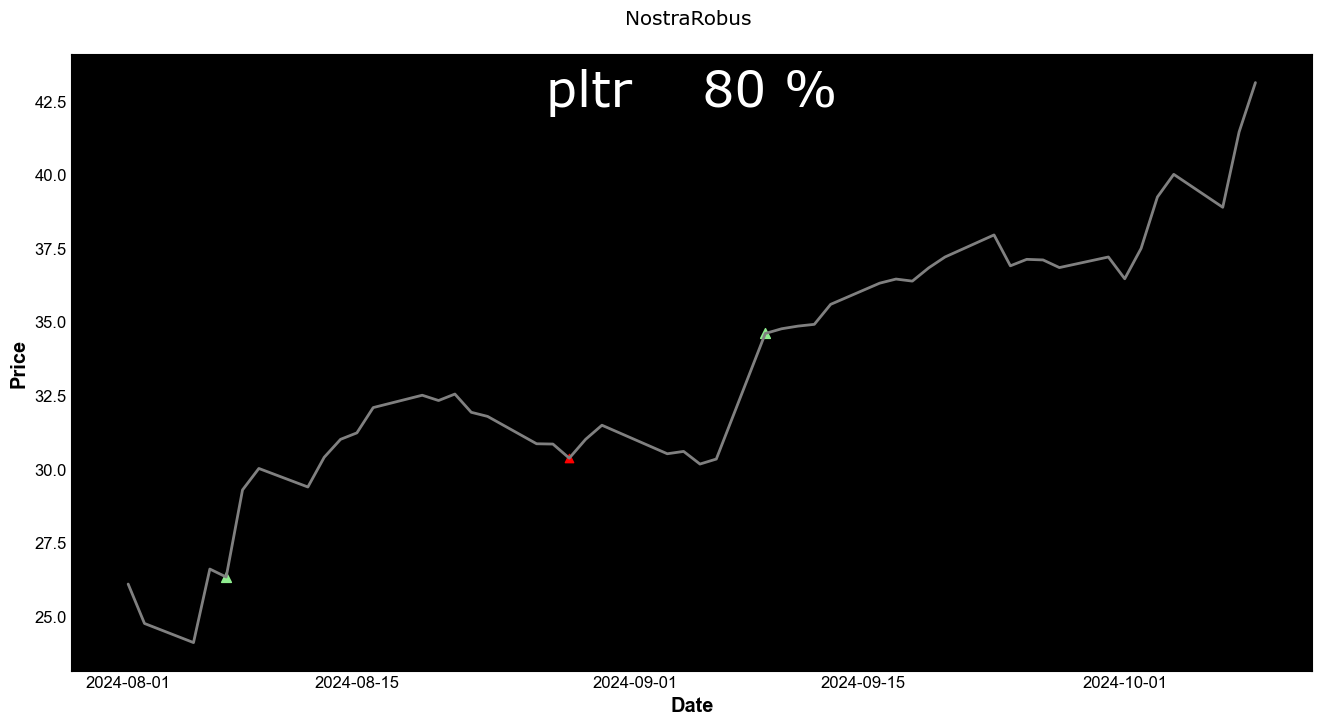

Results For Ticker:   pltr
Initial Investment:  26.31999969482422
Final Portfolio Value:  47
Profit/Loss:  21.0
Percent: 80.0%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-08-07,27.070000,26.320000,26.320000,0.000000
1,Sell,2024-08-28,30.620001,30.360001,30.620001,30.360001
2,Buy,2024-09-09,32.700001,34.599998,34.599998,-4.239998


In [46]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = '' # not being used
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans # not being used

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black



# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
last_close_price = df['Close'].iloc[-1] #get last close price in order to calc our return
portfolio_value =  last_close_price - cash  #portfolio value is our initial purchase price minus last close price.
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment # net difference of our investment and final close price
percent = (profit_loss / initial_investment) * 100 # profit_loss as percent of investment

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



### Same calculation as line graph but with candlestick graph

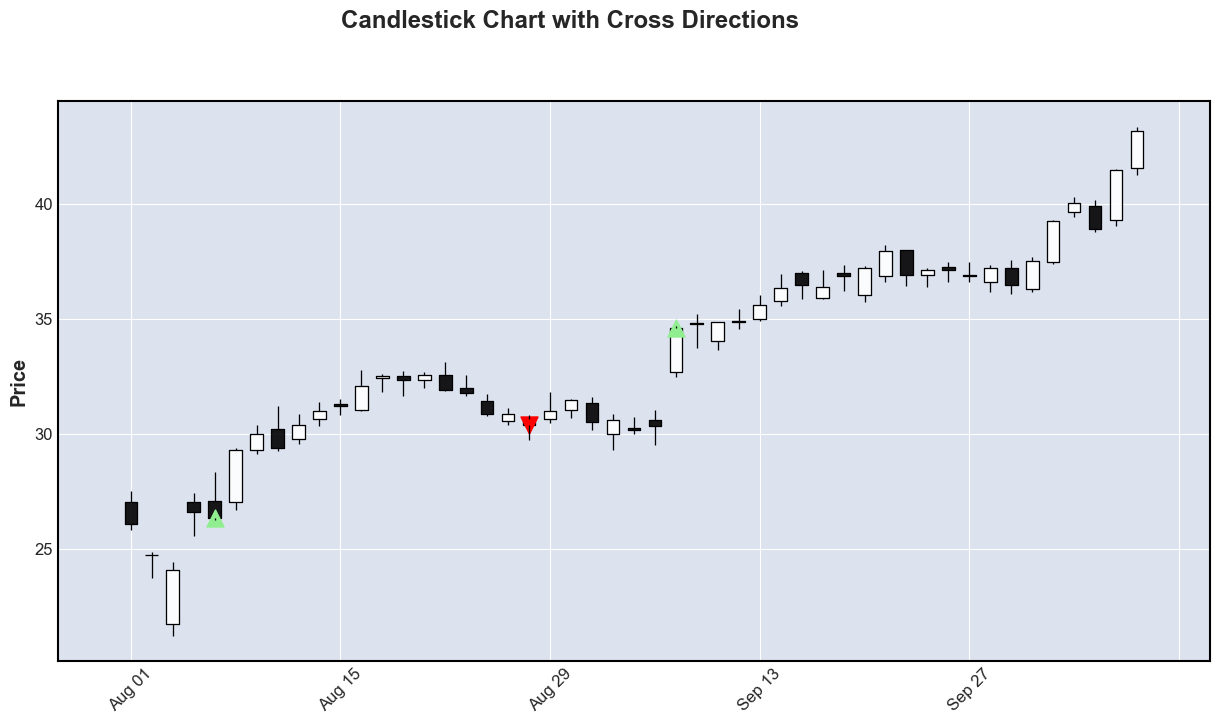

In [47]:
# Plot the candlestick chart with the custom black background
mpf.plot(
    df,
    type='candle',
    title='Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed up', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed down', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


### Intraday Candlestick Graph

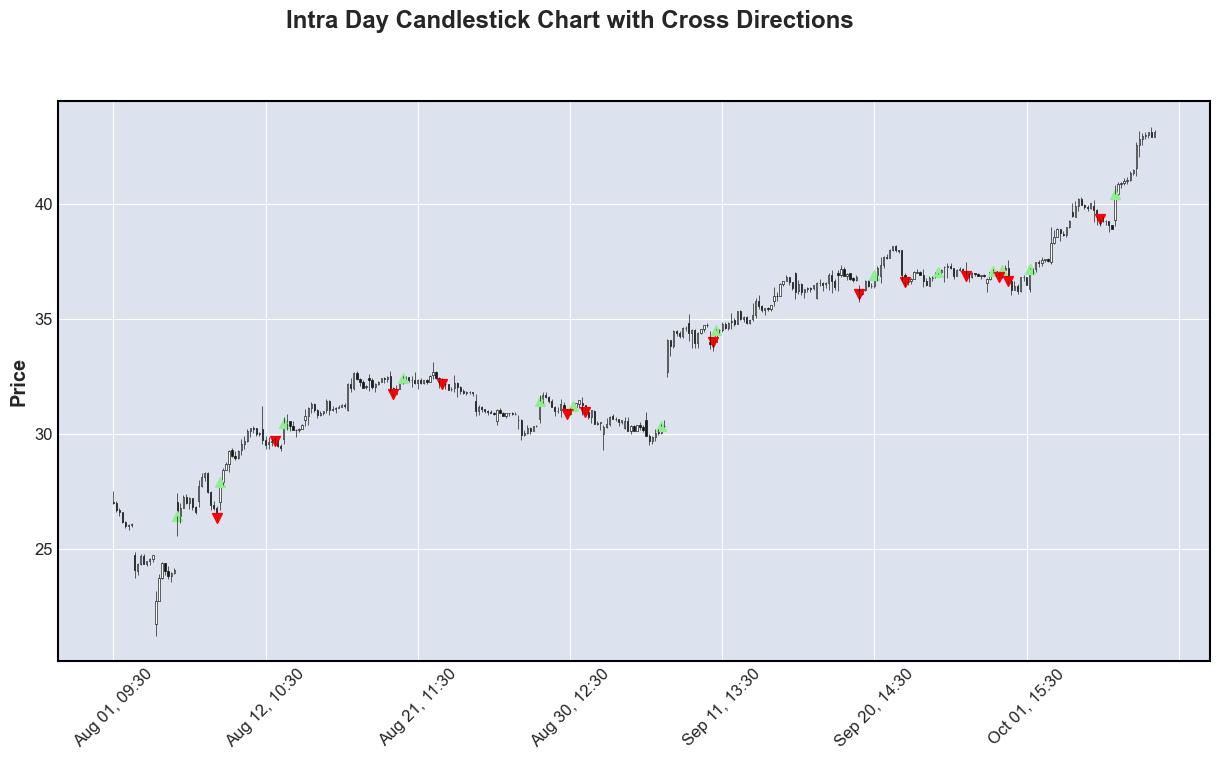

In [48]:
# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    df_intra,
    type='candle',
    title='Intra Day Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_intra) + 1,
    addplot=[
        mpf.make_addplot(
            np.where(df_intra['Cross_Direction'] == 'crossed up', df_intra['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for 'crossed up'
            markersize=50,  # Marker size
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df_intra['Cross_Direction'] == 'crossed down', df_intra['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for 'crossed down'
            markersize=50,  # Marker size
            color='red'      # Color for 'crossed down'
        )
    ]
)